In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
from IPython.display import clear_output

import os
import sys
import time
import gc
import json
import glob
import ast

import shutil
import joblib
import itertools


#needed to import utils.py
sys.path.append('../') 
import utils

import scipy

import numpy as np
import pandas as pd
# config to not reduce column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

# from mycolorpy import colorlist as mcp


import seaborn as sns
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')


import plotly as ply
import plotly.express as px

from itertools import permutations, combinations

from tabulate import tabulate

import pickle
from joblib import dump, load


import sklearn
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier




import shap as shap
shap.initjs()

# import interpret

# from collections import Counter


# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('always')

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline  



/var/folders/qq/dkg27h9s5_d0307n209y943c0000gn/T/ipykernel_10410/703756968.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X_train, y_train, X_valid, y_valid = utils.get_train_and_validation_data(
    scaled=False,
    coded=True,
    use_diagnosis_delay=True,
)

# X_all = pd.concat([X_train, X_valid])
# y_all = pd.DataFrame(np.concatenate((y_train, y_valid)), columns=['Survival_Group'])

y_valid['Class'] = y_valid.Survival_Group.apply(
    lambda x: 'Short' if x == 1 else 'Non-Short'
)

# X_all['Survival_Group'] = y_all


X_decoded_cleaned = utils.get_decoded_data(X_valid)

X_decoded_cleaned.rename(columns={'Diagnosis_Delay': 'Diagnostic_Delay'}, inplace=True)
X_decoded_cleaned


,Sex,Site_Onset,Diagnostic_Delay,Age_at_Onset,Riluzole,FVC_at_Diagnosis,BMI_at_Diagnosis,Q1_Speech_slope_at_Diagnosis,Q2_Salivation_slope_at_Diagnosis,Q3_Swallowing_slope_at_Diagnosis,Q4_Handwriting_slope_at_Diagnosis,Q5_Cutting_slope_at_Diagnosis,Q6_Dressing_and_Hygiene_slope_at_Diagnosis,Q7_Turning_in_Bed_slope_at_Diagnosis,Q8_Walking_slope_at_Diagnosis,Q9_Climbing_Stairs_slope_at_Diagnosis,Q10_Respiratory_slope_at_Diagnosis,Qty_Regions_Involved_at_Diagnosis,Region_Involved_Bulbar_at_Diagnosis,Region_Involved_Upper_Limb_at_Diagnosis,Region_Involved_Lower_Limb_at_Diagnosis,Region_Involved_Respiratory_at_Diagnosis,Patient_with_Gastrostomy_at_Diagnosis
0,Male,Limb/Spinal,Long,60-69,Yes,Normal,Overweight,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Average,Slow,3,No,Yes,Yes,Yes,No
1,Female,Bulbar,Short,40-49,No,Abnormal,Normal,Average,Average,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,1,Yes,No,No,No,No
2,Male,Limb/Spinal,Average,60-69,No,Abnormal,Overweight,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,4,Yes,Yes,Yes,Yes,No
3,Female,Limb/Spinal,Short,40-49,No,Abnormal,Obesity,Average,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Average,Average,4,Yes,Yes,Yes,Yes,No
4,Male,Limb/Spinal,Average,50-59,No,Normal,Obesity,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,1,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,Female,Limb/Spinal,Short,40-49,No,Abnormal,Normal,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,3,No,Yes,Yes,Yes,No
390,Female,Limb/Spinal,Long,60-69,No,Abnormal,Obesity,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Average,Slow,1,No,No,Yes,No,No
391,Female,Limb/Spinal,Short,60-69,No,Normal,Normal,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Average,Average,Slow,1,No,No,Yes,No,No
392,Female,Limb/Spinal,Short,60-69,No,Abnormal,Normal,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,Slow,3,No,Yes,Yes,Yes,No


# Load serialized SHAP values from disk

In [6]:
file = 'saved_shap_explainer/SHAP_KernelExplainer_BalBag_NN.model'
with open(file, 'rb') as fl:
    explainer_loaded = pickle.load(fl)

file = 'saved_shap_explainer/SHAP_KernelExplainer_values_BalBag_NN.model'
# file = 'saved_models/SHAP_explainer_SVM.model'
with open(file, 'rb') as fl:
    shap_values_loaded = pickle.load(fl)


rows_total = shap_values_loaded.shape[0]

rows_max = int (rows_total/3)
rows_max = rows_total

    
shap_values = shap_values_loaded #.values[0:rows_max]    
rows = shap_values.shape[0]

display(rows)

# print(explainer_loaded.feature_names)






394

In [7]:
short_indexes = y_valid.loc[(y_valid.Survival_Group == 1)]
# short_samples = shap_values[short_indexes.index]
# display(short_indexes)

non_short_indexes = y_valid.loc[(y_valid.Survival_Group == 0)]
# non_short_samples = shap_values[non_short_indexes.index]
# display(non_short_indexes)

---
# Create a SHAP $Explanation$ object with the SHAP values loaded from disk

In [17]:
feature_names = []

for f in X_decoded_cleaned.columns:
    feature_names.append(f.replace('_at_Diagnosis', '').replace('_slope',''))

# feature_names


explanation = shap.Explanation(
    values=shap_values.values, 
    base_values=shap_values.base_values[0],
    feature_names=feature_names,
    data = X_decoded_cleaned.values,
)

explanation


.values =
array([[ 0.01759718, -0.00856642, -0.11551264, ..., -0.00276435,
         0.00278956,  0.        ],
       [-0.07055123,  0.10232204,  0.32018594, ...,  0.14085954,
        -0.0128383 ,  0.00670929],
       [ 0.02752167, -0.01500458, -0.08662753, ..., -0.00780104,
         0.00965182,  0.        ],
       ...,
       [-0.13360074, -0.04754076,  0.16139987, ..., -0.0255424 ,
        -0.0020139 ,  0.00439732],
       [-0.05942945, -0.02218937,  0.12484273, ..., -0.01278397,
         0.01502911,  0.00137506],
       [-0.12603943,  0.0703607 , -0.18066023, ..., -0.02781204,
        -0.0111765 ,  0.00448496]])

.base_values =
0.2918781725888325

.data =
array([['Male', 'Limb/Spinal', 'Long', ..., 'Yes', 'Yes', 'No'],
       ['Female', 'Bulbar', 'Short', ..., 'No', 'No', 'No'],
       ['Male', 'Limb/Spinal', 'Average', ..., 'Yes', 'Yes', 'No'],
       ...,
       ['Female', 'Limb/Spinal', 'Short', ..., 'Yes', 'No', 'No'],
       ['Female', 'Limb/Spinal', 'Short', ..., 'Yes', 'Yes',

# Generate graphs for each Patient to help choosing best graph to put in the paper

In [138]:
# # df = X_decoded_cleaned.iloc[short_indexes.index].reset_index()
# # df = df.loc[(
# #     # (df.Sex == 'Male')
# #     # &(df.Age_at_Onset == '60-69')
# #     (df.Diagnosis_Delay == 'Short')
# #     &(df.Q1_Speech_slope_at_Diagnosis == 'Rapid')
# #     &(df.Q9_Climbing_Stairs_slope_at_Diagnosis == 'Rapid')
# # )]

# # display(df)


# # display(X_decoded_cleaned.head(5))

# # ====================================
# # DECISION PLOT FOR ALL PATIENTS
# # ====================================
# for i in np.arange(0, len(explanation.values)):
# # for i in df.index:
#     fig, ax = plt.subplots(figsize=(5,5) )
#     shap.decision_plot(
#         explanation.base_values,
#         explanation.values[i],
#         X_decoded_cleaned.iloc[i],
#         feature_names=feature_names,
#     #     feature_order='none',
#         show=False,
#     )
#     plt.title(f'index: {i}', fontsize=12)
#     # plt.show()

#     group = y_valid.iloc[i].values[1]
#     # print(group)
    
#     utils.save_plot(
#         plt=plt, 
#         folder=f'temp_shap_plots/{group}', 
#         file_name=f'patient_index_{i}_{group}', 
#         save_in_pdf_format=False,
#     )

#     plt.close()

#     print(f'{i}', end='..')
    


---
# Plot SHAP graphs

### Define some variables

In [9]:
x_jitter = 0.2
dot_size=3
max_display = 23

display_range = slice(-1, -(max_display+1), -1)

feature_natural_order = list(range(0, 23, 1))

figsize_default = [10,5]
x_ticks_default = [-0.01, 0., 1., 1.5]
x_ticks_default_labels  = ['', 'Non-Short', 'Short', '']


## Plot SHAP Decision graphs for patients $A$ and $B$

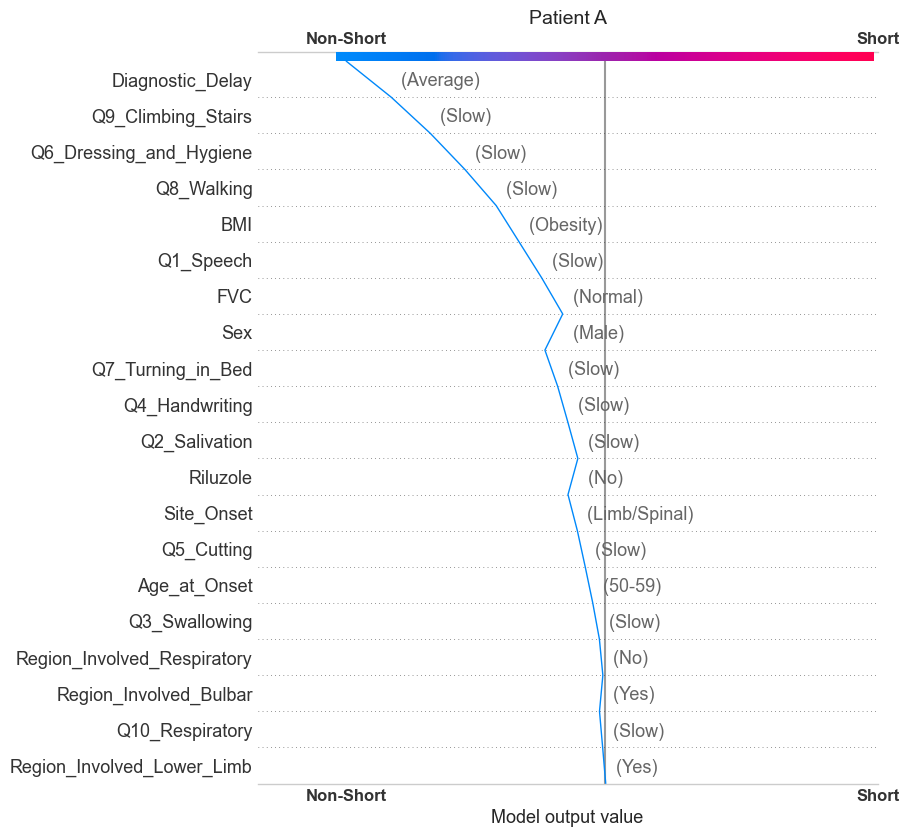

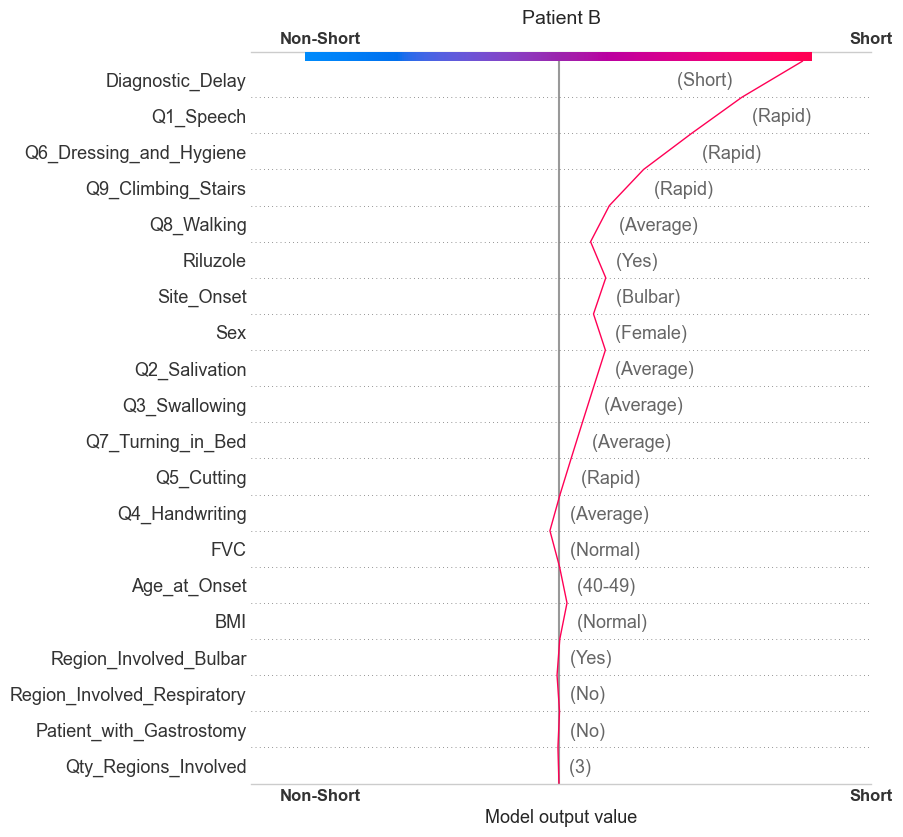

In [7]:
idx_patient_A = 6 #27
idx_patient_B = 352


# ====================================
# DECISION PLOT FOR PATIENT A
# ====================================
fig, ax = plt.subplots(figsize=figsize_default)
shap.decision_plot(
    explanation.base_values,
    explanation.values[non_short_indexes.index[idx_patient_A]],
    X_decoded_cleaned.iloc[idx_patient_A],
    feature_names=feature_names,
#     feature_order='none',
    show=False,
)

utils.customize_xticks(ax=ax, fontsize=12)

plt.title('Patient A', fontsize=14)

plt.grid(False)
# plt.tight_layout()

utils.save_plot(
    plt=plt, 
    folder='saved_graphs', 
    file_name='patient_A_decision_plot', 
    save_in_pdf_format=True,
)

plt.show()

plt.close()

# ====================================
# DECISION PLOT FOR PATIENT B
# ====================================
fig, ax = plt.subplots(figsize=figsize_default)
shap.decision_plot(
    explanation.base_values,
    explanation.values[idx_patient_B],
    X_decoded_cleaned.iloc[idx_patient_B],
    feature_names=feature_names,
#     feature_order='none',
    show=False,
)

utils.customize_xticks(ax=ax, fontsize=12)

plt.title('Patient B', fontsize=14)

plt.grid(False)

utils.save_plot(
    plt=plt, 
    folder='saved_graphs', 
    file_name='patient_B_decision_plot', 
    save_in_pdf_format=True,
)

plt.show()
plt.close()





# Plot SHAP Decision for both patients ($A$ and $B$)


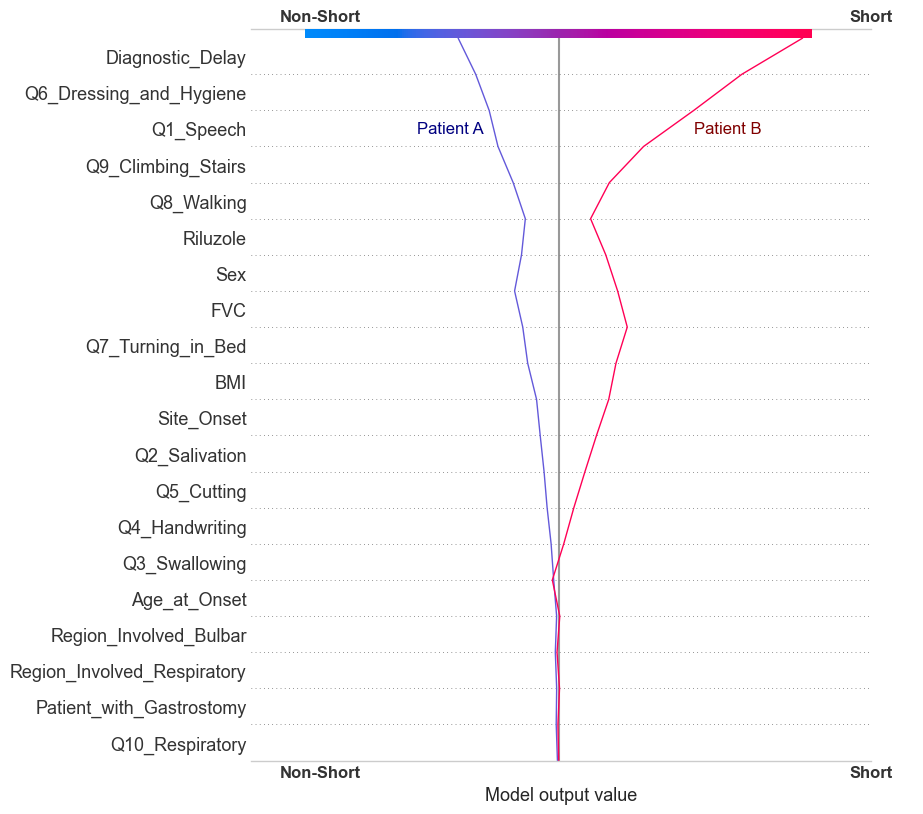

In [8]:
# plot both patients

data_shap = np.array([
    explanation.values[idx_patient_A],
    explanation.values[idx_patient_B],
])

fig, ax = plt.subplots(figsize=figsize_default)

# for row in data_shap:
shap.decision_plot(
    explanation.base_values,
    data_shap, 
    feature_names=feature_names,
    show=False,
#         link='logit'
#     highlight=1,
    # legend_labels=['Patient A', 'Patient B'],
    # legend_location='center right',
    # legend_fontsize=14,
 
)

# ax.legend(
#     ['Patient A', 'Patient B'], 
#     fontsize=12, 
#     loc='center right', 
#     # labelcolor=['red', 'blue'],
#     # color=['red', 'blue']
# )

ax.annotate(
    'Patient A', 
    xy=(300, 490), 
    xycoords='figure points', 
    size=12, 
    color='navy',
    # weight='bold'
) 

ax.annotate(
    'Patient B', 
    xy=(500, 490), 
    xycoords='figure points', 
    size=12,
    color='maroon',
    # weight='bold'
) 


utils.customize_xticks(ax=ax, fontsize=12)

plt.grid(False)
plt.legend('')

utils.save_plot(
    plt=plt, 
    folder='saved_graphs', 
    file_name='comparing_patient_A_and_B_decision_plot', 
    save_in_pdf_format=True,
)

plt.show()



# Plot Beeswarm for all patients


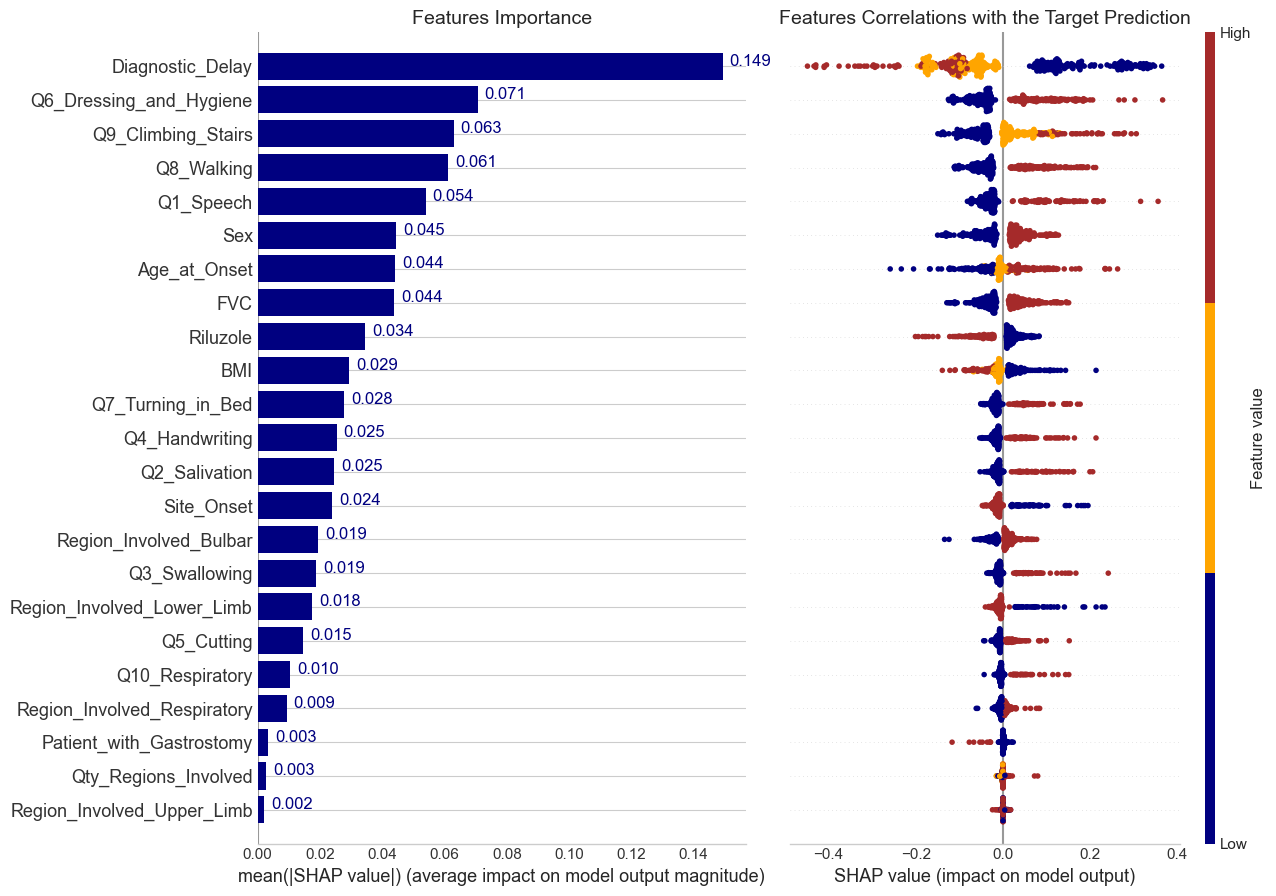

In [9]:
# plot both patients

fig = plt.figure(figsize=(15,5))

# ax1 = plt.subplot2grid(shape=(1, 3), loc=(0, 0))

ax1 = fig.add_subplot(121)


# Bar plot
shap.summary_plot(
    explanation, 
    X_valid, 
    max_display=max_display,
    plot_type="bar",
    show=False,
    color='navy',
    # midline_decimal_point=False,

)
# ax1.title.set_text('Absolute Feature Impact', fontdict={'fontsize':12})
ax1.set_title('Features Importance', fontdict={'fontsize':14})



utils.annotate_barplot(
    ax=ax1, 
    midline_decimal_point=False, 
    font_size=12,
    deslocate=0.15,
    color='navy'
)
ax1.grid(axis='x')

# Beeswarm plot
ax2 = fig.add_subplot(122)
# ax2 = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=2)

# colors = mcp.gen_color(cmap='tab20', n=3)
colors = ListedColormap(['navy', 'orange', 'brown'])


shap.summary_plot(
    explanation, 
    X_valid, 
    max_display=max_display,
    show=False,
    plot_size=(13,9),
    cmap=colors,
    # midline_decimal_point=False,
)
# ax2.title.set_text('Distribution')
ax2.set_title('Features Correlations with the Target Prediction', fontdict={'fontsize':14})


ax2.get_yaxis().set_visible(False)

ax2.get_yaxis().set_label_text('')
# ax2.get_yaxis().title('')



plt.tight_layout()
plt.grid(False)

# plt.savefig(
#     f'saved_graphs/SHAP_0_Feature_Importance_and Beeswarm.png', 
#     bbox_inches='tight', 
#     dpi=300
# )

utils.save_plot(
    plt=plt, 
    folder='saved_graphs', 
    file_name='SHAP_0_Feature_Importance_and_Beeswarm', 
    save_in_pdf_format=True,
)


plt.show()


# Plot the model $output$ $impact$ for each $value$ of each $feature$

['Diagnostic_Delay' 'Q6_Dressing_and_Hygiene' 'Q9_Climbing_Stairs'
 'Q8_Walking' 'Q1_Speech' 'Sex' 'Age_at_Onset' 'FVC' 'Riluzole' 'BMI'
 'Q7_Turning_in_Bed' 'Q4_Handwriting' 'Q2_Salivation' 'Site_Onset'
 'Region_Involved_Bulbar' 'Q3_Swallowing' 'Region_Involved_Lower_Limb'
 'Q5_Cutting' 'Q10_Respiratory' 'Region_Involved_Respiratory'
 'Patient_with_Gastrostomy' 'Qty_Regions_Involved'
 'Region_Involved_Upper_Limb']


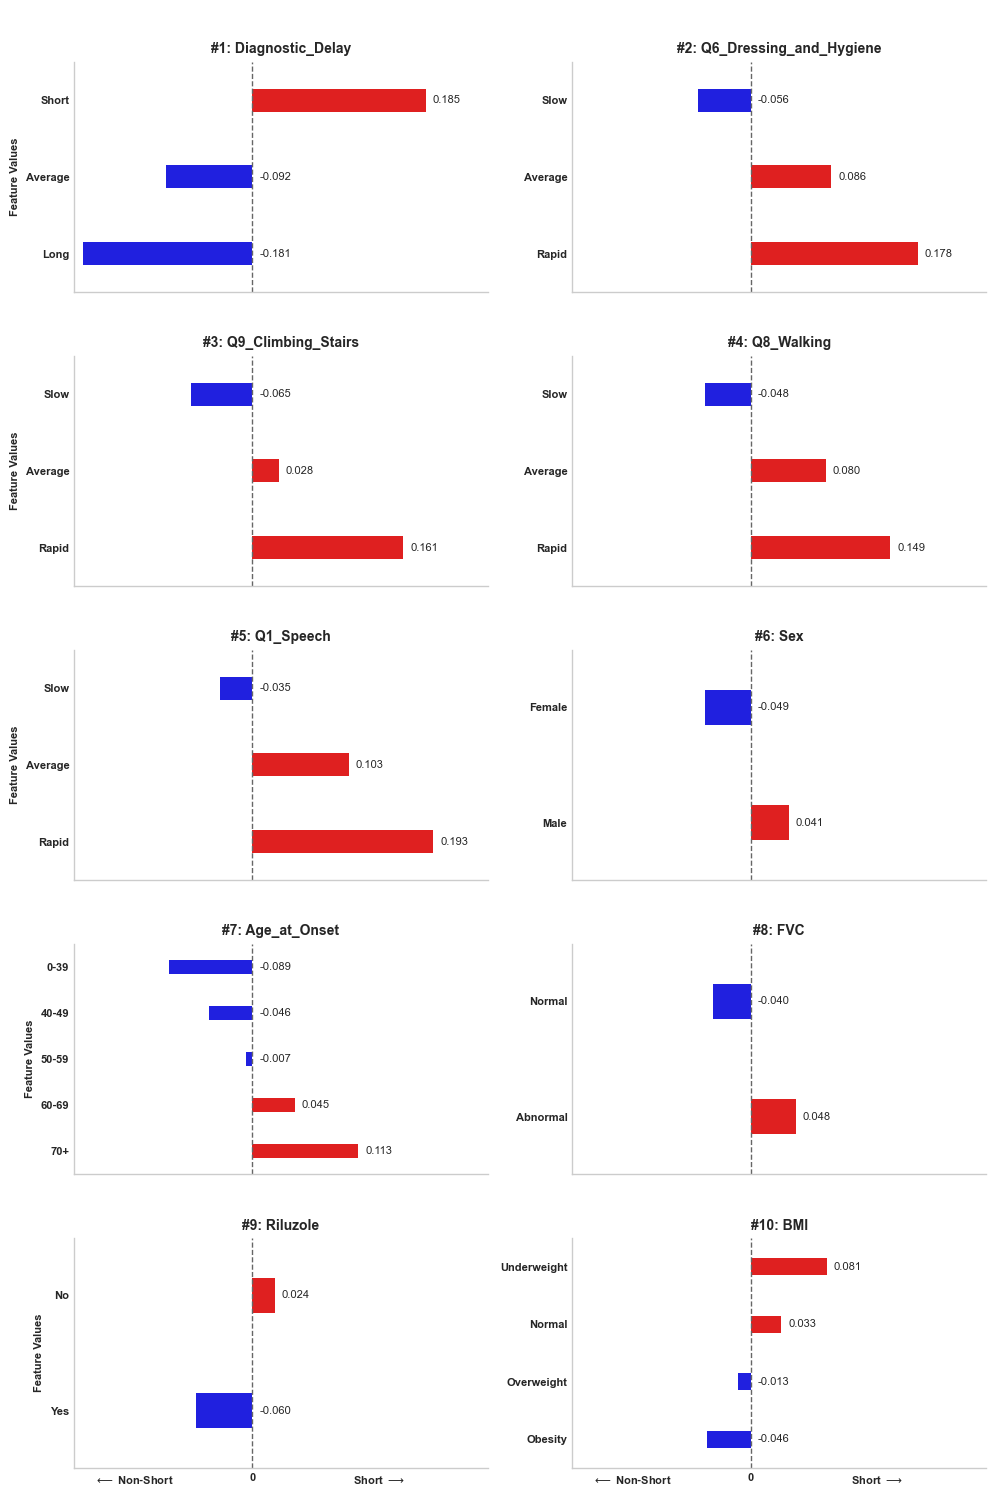

In [14]:
# explanation_cohort = shap.Explanation(
#     np.round(shap_values, 3), 
#     base_values=base_value,
#     feature_names=feature_names,
#     # data = X_valid.values,
#     data = X_decoded.values,
# )

explanation_cohort = explanation

dfs = []

min_shap_value = 0.0
max_shap_value = 0.0

for ind_feat, feat in enumerate(feature_names):

    # get cohort for the feature
    cohort = explanation_cohort.data[:, ind_feat]

    # get cohort-shap-values for the feature-cohort
    cohort_shap_values = explanation_cohort.cohorts(cohort)

    
    # get feature values description
    feat_values = []
    feat_values_aux = cohort_shap_values.cohorts.keys()
    for f_value in feat_values_aux:
        try:
            feat_values.append(f_value.split(')')[1].strip())
        except: 
            feat_values.append(f_value)
    
    
    # store feature values SHAP-values
    feat_shap_values = []

    # for each value of the feature
    for key in feat_values_aux:
        # get shap-values for feature-value
        shaps_key = cohort_shap_values.cohorts[key]
        # calculate the mean of the shap-values
        shaps_key_mean = np.round(shaps_key[:, ind_feat].values.mean(), 3)
        # store mean shap-value for the feature-value
        feat_shap_values.append(shaps_key_mean)

    
    # create DataFrame with the SHAP data
    data = {
        'Feature Values': feat_values,
        'mean(SHAP value) by feature values': feat_shap_values,
    }
    df = pd.DataFrame(data)


    df['col_to_order'] = df['Feature Values'].apply(lambda x: utils.set_feature_values_order(x))

    # sort features
    df.sort_values(by=['col_to_order'], ascending=True, inplace=True)

    # display(df)

    # asdasd

    # store the DataFrames created by each feature
    dfs.append([feat, len(feat_values), df])
    
    # store the min and max overall shap-value
    min_shap_value = np.min([min_shap_value, np.min(feat_shap_values)])
    max_shap_value = np.max([max_shap_value, np.max(feat_shap_values)])

# display(dfs)   



mask = np.abs(explanation.values).mean(0).argsort()[::-1]
# print(mask, explanation.feature_names)
# features_ordered_names = X_decoded_cleaned.columns[mask]
features_ordered_names = np.array(explanation.feature_names)[mask]

print(features_ordered_names)

folder_to_save = os.path.abspath('saved_graphs')

# print(features_ordered_names)
# print(dfs)

utils.plot_shap_values_by_feature_in_one_graph(
        data_frames=dfs, 
        features_ordered_names=features_ordered_names,
        figsize=[10, 15],
        bar_height=0.3,
        x_min=min_shap_value,
        x_max=max_shap_value,
        midline_decimal_point=False,
        folder_to_save=folder_to_save,
        qty_features=10,
        file_name = 'SHAP_by_feature_values' 
)



---
---
---
---
---
# OTHER TESTS
---
---
---
---
---